In this notebook, we find a reasonable data processing strategy and model for classifying text from a dataset of wikipedia comments (https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data) using a "bag of words" approach. The best model tried here (considering both speed and performance) is a multilayer perceptron (MLP) model trained with tensorflow.keras. This matches the recommendation in https://developers.google.com/machine-learning/guides/text-classification/step-2-5 (see the comment a few cells below).

Some code based off of the following references:
- The book **Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow** by Aurelien Geron
- Google Developer's Machine Learning Text Classification Guide (https://developers.google.com/machine-learning/guides/text-classification)
- https://github.com/tianqwang/Toxic-Comment-Classification-Challenge/blob/master/Toxic_Comment_Classification.ipynb
- https://github.com/scatkinson/is_your_advice_unethical/blob/main/EthicalTips.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
full_data = pd.read_csv('wiki_toxic.csv')

In [12]:
"""Computes the ratio of number of samples to average number of words per sample."""

num_samples = len(full_data)
mean_wps = full_data['comment_text'].str.len().mean()
ratio = num_samples/mean_wps
ratio

404.92728600944315

According to the reference https://developers.google.com/machine-learning/guides/text-classification/step-2-5, for a ratio under 1500, the recommended best data processing strategy is a bag-of-words approach (as opposed to a sequence approach) and the recommended best model is a MLP model. I have not explored the sequence approach yet, but MLP models did indeed seems to perform the best (and were much faster than the next best model type, which was the support vector classifier).

In [4]:
full_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
full_data.shape

(159571, 8)

In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
full_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


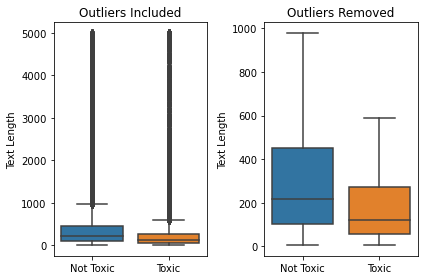

In [8]:
"""This answers the question: how does toxicity relate to length of the post?
Evidently, non-toxic posts are generally longer than toxic posts."""

import seaborn as sns

full_data['text_length'] = full_data['comment_text'].str.len()

fig, ax = plt.subplots(1, 2);
sns.boxplot(x='toxic', y='text_length', data=full_data, showfliers=True, ax=ax[0]);
sns.boxplot(x='toxic', y='text_length', data=full_data, showfliers=False, ax=ax[1]);
ax[0].set_title('Outliers Included');
ax[1].set_title('Outliers Removed');
for k in [0, 1]:
    ax[k].set_xticks([0, 1], ['Not Toxic', 'Toxic']);
    ax[k].set_xlabel('');
    ax[k].set_ylabel('Text Length');
fig.tight_layout();

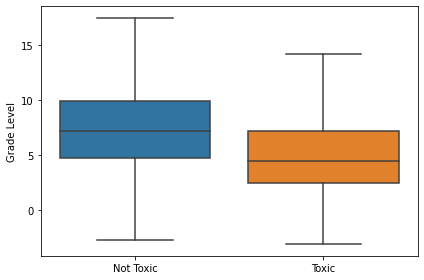

In [122]:
"""As one more interesting analysis step before diving into the vectorization and model-training process,
this computes the Flesch-Kincaid grade level for each post and compares the non-toxic/toxic categories on this.
Evidently, non-toxic posts are of a higher grade level in general.

See https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level
for more information on this score."""

import textstat

if 'grade_level' not in full_data.columns:
    full_data['grade_level'] = full_data['comment_text'].apply(textstat.flesch_kincaid_grade)

fig, ax = plt.subplots();
sns.boxplot(x='toxic', y='grade_level', data=full_data, showfliers=False);
ax.set_xticks([0, 1], ['Not Toxic', 'Toxic']);
ax.set_xlabel('');
ax.set_ylabel('Grade Level');
fig.tight_layout();

In [8]:
X_full = full_data['comment_text']
y_full = full_data['toxic']

In [9]:
"""Randomly shuffle and split the full data set into a training set (80%) and test set (20%)."""
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [10]:
"""To keep things running reasonably quickly, we get a sample from the dataset by keeping all
the toxic posts and randomly selecting from the non-offensive posts.
We then check that the instance indices match the label indices."""

keep_num=30000

X_toxic = X_train[y_train == 1]
X_nontoxic = X_train[y_train == 0].sample(n=keep_num - len(X_toxic), random_state=34)
X_sampled = pd.concat([X_toxic, X_nontoxic]).sample(frac=1, random_state=33)

y_toxic = y_train[y_train == 1]
y_nontoxic = y_train[y_train == 0].sample(n=keep_num - len(X_toxic), random_state=34)
y_sampled = pd.concat([y_toxic, y_nontoxic]).sample(frac=1, random_state=33)

X_sampled.index.equals(y_sampled.index)

True

In [11]:
"""A simple tokenizer for data preprocessing."""

import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
import re
from nltk.stem.wordnet import WordNetLemmatizer
import string

def tokenizer_simple(text):
    """
    Tokenizes text by making everything lowercase, removing punctuation and unallowed symbols,
    removing any non-ascii code, and lemmatizing words.
    """
    text = text.lower()
    unallowed = '0-9\r\t\n'
    regex = re.compile(r'[' + re.escape(string.punctuation) + unallowed +']')
    nopunct = regex.sub(' ', text)
    words = nopunct.split(' ')
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    words = [word for word in words if len(word) > 2]
    return words

In [12]:
"""Alternate tokenizer with a more sophisticated lemmatizer using POS tagging."""

import re
import string
import spacy
nlp = spacy.load('en_core_web_sm')

def tokenizer_pos(text):
    """
    Tokenizes text by making everything lowercase, removing punctuation and unallowed symbols,
    removing any non-ascii code, and lemmatizing words.
    """
    text = text.lower()
    unallowed = '0-9\r\t\n'
    regex = re.compile(r'[' + re.escape(string.punctuation) + unallowed +']')
    nopunct = regex.sub(' ', text)
    words = nopunct.split(' ')
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    doc = nlp(text)
    words = [token.lemma_ for token in doc]
    words = [word for word in words if len(word) > 2]
    return words

In [13]:
"""A pipeline that vectorizes words and selects the most relevant features."""

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif

kwargs = {
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': 'word',
    'min_df': 2,
}

vectorize_and_select_pipeline = Pipeline([
    ('vectorize', TfidfVectorizer(**kwargs)),
    ('select', SelectKBest(f_classif)),
])

In [14]:
"""An example of how to set the pipeline's parameters and use it to fit and transform the training set."""

vectorize_and_select_pipeline.set_params(vectorize__tokenizer=tokenizer_simple,
                                         vectorize__ngram_range=(1,2),
                                         select__k=20000)

X_train_v = vectorize_and_select_pipeline.fit_transform(X_sampled, y_sampled)

X_train_v.shape

(30000, 20000)

In [15]:
"""A function that gets clean predicted labels given a model, (vectorized) training data, and a name that describes
the model, then prints the model name and corresponding confusion matrix, precision, recall, and F_1 scores."""

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve

def predict_eval(model, X_train_v, y_train, model_name=''):
    y_train_pred = cross_val_predict(model, X_train_v, y_train, cv=3)
    print(model_name, '\n',
          'Confusion Matrix:\n', confusion_matrix(y_train, y_train_pred), '\n\n',
          'Precision: ', precision_score(y_train, y_train_pred), '\n',
          'Recall:    ', recall_score(y_train, y_train_pred), '\n',
          'F_1:       ', f1_score(y_train, y_train_pred),
         )

In [15]:
"""A grid search that tries out a variety of models on various text prep strategies,
and also keeps track of how long each text prep step and classifier takes.
(This is perhaps overkill, but I was curious to see.)"""

import time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

nb_clf = MultinomialNB()
lg_clf = LogisticRegression(max_iter=200)
sv_clf = SVC()
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

classifiers = {'Naive Bayes': nb_clf,
               'Logistic': lg_clf,
               'Support Vector': sv_clf,
               'Random Forest': rf_clf,
               'AdaBoost': ada_clf,
               'XGBoost': xgb_clf,
              }

kwargs = {
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': 'word',
    'min_df': 2,
}

ngram_choices = [(1,1), (1,2)]
tokenizer_choices = [tokenizer_simple, tokenizer_pos]
top_k_choices = [15000, 20000]

temp_time = time.time()

for ngram_range in ngram_choices:
    for tokenizer in tokenizer_choices:
        for top_k in top_k_choices:
            print('ngram range: ' + str(ngram_range))
            print('tokenizer: ' + tokenizer.__name__)
            print('top_k: ' + str(top_k))
            #The try-except here is to deal with the possibility that there are less than top_k features after vectorizing.
            try:
                vectorize_and_select_pipeline.set_params(vectorize__ngram_range=ngram_range,
                                                         vectorize__tokenizer=tokenizer,
                                                         select__k=top_k)
                X_train_v = vectorize_and_select_pipeline.fit_transform(X_sampled, y_sampled)
            except ValueError:
                vectorize_and_select_pipeline.set_params(vectorize__ngram_range=ngram_range,
                                                         vectorize__tokenizer=tokenizer,
                                                         select__k='all')
                X_train_v = vectorize_and_select_pipeline.fit_transform(X_sampled, y_sampled)
            elapsed_time = time.time() - temp_time
            temp_time = time.time()
            print('Data prep time: ' + str(elapsed_time) +'\n')
            for model_name, model in classifiers.items():
                predict_eval(model, X_train_v, y_sampled, model_name=model_name)                
                elapsed_time = time.time() - temp_time
                temp_time = time.time()
                print('\n' + 'Model cross validation time: ' + str(elapsed_time) + '\n')

ngram range: (1, 1)
tokenizer: tokenizer_simple
top_k: 15000
Data prep time: 12.043896913528442

Naive Bayes 
 Confusion Matrix:
 [[17018   744]
 [ 2580  9658]] 

 Precision:  0.9284752932128437 
 Recall:     0.789181238764504 
 F_1:        0.8531802120141343

Model cross validation time: 0.08217692375183105

Logistic 
 Confusion Matrix:
 [[16867   895]
 [ 2265  9973]] 

 Precision:  0.9176481413323518 
 Recall:     0.8149207386827914 
 F_1:        0.8632389855448802

Model cross validation time: 0.7854430675506592

Support Vector 
 Confusion Matrix:
 [[16930   832]
 [ 2021 10217]] 

 Precision:  0.9246990677889402 
 Recall:     0.8348586370321948 
 F_1:        0.8774852922231288

Model cross validation time: 487.45681595802307

Random Forest 
 Confusion Matrix:
 [[16892   870]
 [ 3209  9029]] 

 Precision:  0.9121123345792504 
 Recall:     0.7377839516260827 
 F_1:        0.8157383565975515

Model cross validation time: 82.06661200523376

AdaBoost 
 Confusion Matrix:
 [[16379  1383]
 

Data prep time: 392.1509487628937

Naive Bayes 
 Confusion Matrix:
 [[17244   518]
 [ 2812  9426]] 

 Precision:  0.9479082864038616 
 Recall:     0.77022389279294 
 F_1:        0.8498782796862321

Model cross validation time: 0.08181095123291016

Logistic 
 Confusion Matrix:
 [[16852   910]
 [ 2465  9773]] 

 Precision:  0.9148179350369746 
 Recall:     0.7985781990521327 
 F_1:        0.8527551153963614

Model cross validation time: 0.6086640357971191

Support Vector 
 Confusion Matrix:
 [[16957   805]
 [ 1868 10370]] 

 Precision:  0.9279642058165548 
 Recall:     0.8473606798496487 
 F_1:        0.8858326570708582

Model cross validation time: 553.7879528999329

Random Forest 
 Confusion Matrix:
 [[17054   708]
 [ 3323  8915]] 

 Precision:  0.9264262703938481 
 Recall:     0.7284687040366072 
 F_1:        0.8156077032157723

Model cross validation time: 76.45986199378967

AdaBoost 
 Confusion Matrix:
 [[16344  1418]
 [ 3054  9184]] 

 Precision:  0.8662516506319562 
 Recall:     0

We now explore some MLP neural networks.

In [16]:
"""First, build the vectorized training set using the a reasonable prep strategy based on the grid search above.
Note that we also convert X_train_v to a numpy array so that it is compatible with keras."""

vectorize_and_select_pipeline.set_params(vectorize__ngram_range=(1,2),
                                         vectorize__tokenizer=tokenizer_simple,
                                         select__k=20000)
X_train_v = vectorize_and_select_pipeline.fit_transform(X_sampled, y_sampled)
X_train_v = X_train_v.toarray()

In [14]:
"""Function that builds an MLP model for various parameters."""

from tensorflow import keras
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

def build_mlp_model(n_hidden=3, n_neurons=30, dropout_rate=0.3, input_shape=20000,):
    model = keras.models.Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Dropout(rate=dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(units=n_neurons, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [32]:
from scikeras.wrappers import KerasClassifier

keras_clf = KerasClassifier(model=build_mlp_model,
                            epochs=6,
                            verbose=1)

predict_eval(keras_clf, X_train_v, y_sampled, model_name='MLP')

Epoch 1/6
625/625 [==============================] - 6s 8ms/step - loss: 0.4268 - accuracy: 0.8057
Epoch 2/6
625/625 [==============================] - 5s 7ms/step - loss: 0.2811 - accuracy: 0.8905
Epoch 3/6
625/625 [==============================] - 5s 7ms/step - loss: 0.2541 - accuracy: 0.9007
Epoch 4/6
625/625 [==============================] - 5s 7ms/step - loss: 0.2408 - accuracy: 0.9090
Epoch 5/6
625/625 [==============================] - 5s 7ms/step - loss: 0.2310 - accuracy: 0.9112
Epoch 6/6
313/313 [==============================] - 1s 2ms/step
Epoch 1/6
625/625 [==============================] - 6s 9ms/step - loss: 0.4303 - accuracy: 0.8037
Epoch 2/6
625/625 [==============================] - 5s 8ms/step - loss: 0.2915 - accuracy: 0.8834
Epoch 3/6
625/625 [==============================] - 5s 7ms/step - loss: 0.2625 - accuracy: 0.8971
Epoch 4/6
625/625 [==============================] - 5s 8ms/step - loss: 0.2427 - accuracy: 0.9071
Epoch 5/6
625/625 [=========================

In [19]:
"""Again, but a bigger model."""

from scikeras.wrappers import KerasClassifier

keras_clf = KerasClassifier(model=build_mlp_model(n_hidden=5, n_neurons=100),
                            epochs=6,
                            verbose=1)

predict_eval(keras_clf, X_train_v, y_sampled, model_name='Bigger MLP')

2022-06-08 09:40:39.076981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ram:///var/folders/3d/8nmtnnsj0n53170j0cb2mtdr0000gn/T/tmpcnp2q12w/assets
Epoch 1/6
625/625 [==============================] - 23s 34ms/step - loss: 0.3695 - accuracy: 0.8395
Epoch 2/6
625/625 [==============================] - 21s 34ms/step - loss: 0.2631 - accuracy: 0.8972
Epoch 3/6
625/625 [==============================] - 22s 35ms/step - loss: 0.2379 - accuracy: 0.9097
Epoch 4/6
625/625 [==============================] - 24s 38ms/step - loss: 0.2390 - accuracy: 0.9086
Epoch 5/6
625/625 [==============================] - 22s 34ms/step - loss: 0.2280 - accuracy: 0.9143
Epoch 6/6
313/313 [==============================] - 2s 6ms/step
INFO:tensorflow:Assets written to: ram:///var/folders/3d/8nmtnnsj0n53170j0cb2mtdr0000gn/T/tmp7l33xstd/assets
Epoch 1/6
625/625 [==============================] - 22s 33ms/step - loss: 0.3715 - accuracy: 0.8340
Epoch 2/6
625/625 [==============================] - 19s 31ms/step - loss: 0.2650 - accuracy: 0.8937
Epoch 3/6


In [27]:
"""Similarly to the above, a function that builds an MLP model, but this time with different
configuration parameters (based on the default suggestion in HOML)."""

def build_mlp_model_2(n_hidden=3, n_neurons=30, dropout_rate=0.1,
                    kernel_initializer='he_normal', activation='elu', input_shape=20000,):
    model = keras.models.Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Dropout(rate=dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(units=n_neurons, kernel_initializer=kernel_initializer,
                        activation=activation))
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [29]:
keras_clf = KerasClassifier(model=build_mlp_model_2,
                            epochs=6,
                            verbose=1)

predict_eval(keras_clf, X_train_v, y_sampled, model_name='MLP new config')

Epoch 1/6
625/625 [==============================] - 7s 10ms/step - loss: 0.3020 - accuracy: 0.8718
Epoch 2/6
625/625 [==============================] - 5s 8ms/step - loss: 0.2101 - accuracy: 0.9154
Epoch 3/6
625/625 [==============================] - 5s 8ms/step - loss: 0.1918 - accuracy: 0.9241
Epoch 4/6
625/625 [==============================] - 5s 8ms/step - loss: 0.1824 - accuracy: 0.9291
Epoch 5/6
625/625 [==============================] - 5s 8ms/step - loss: 0.1750 - accuracy: 0.9309
Epoch 6/6
313/313 [==============================] - 1s 2ms/step
Epoch 1/6
625/625 [==============================] - 6s 8ms/step - loss: 0.3001 - accuracy: 0.8686
Epoch 2/6
625/625 [==============================] - 5s 8ms/step - loss: 0.2076 - accuracy: 0.9154
Epoch 3/6
625/625 [==============================] - 5s 7ms/step - loss: 0.1887 - accuracy: 0.9248
Epoch 4/6
625/625 [==============================] - 5s 8ms/step - loss: 0.1778 - accuracy: 0.9293
Epoch 5/6
625/625 [========================

In [30]:
keras_clf = KerasClassifier(model=build_mlp_model_2(n_hidden=5, n_neurons=100),
                            epochs=6,
                            verbose=1)

predict_eval(keras_clf, X_train_v, y_sampled, model_name='Bigger MLP new config')

INFO:tensorflow:Assets written to: ram:///var/folders/50/rdh34pg55352g7f55r28b2wm0000gq/T/tmpreplembs/assets
Epoch 1/6
625/625 [==============================] - 15s 22ms/step - loss: 0.2861 - accuracy: 0.8832
Epoch 2/6
625/625 [==============================] - 14s 22ms/step - loss: 0.2109 - accuracy: 0.9162
Epoch 3/6
625/625 [==============================] - 13s 20ms/step - loss: 0.1931 - accuracy: 0.9237
Epoch 4/6
625/625 [==============================] - 13s 21ms/step - loss: 0.1847 - accuracy: 0.9293
Epoch 5/6
625/625 [==============================] - 13s 20ms/step - loss: 0.1800 - accuracy: 0.9288
Epoch 6/6
313/313 [==============================] - 1s 3ms/step
INFO:tensorflow:Assets written to: ram:///var/folders/50/rdh34pg55352g7f55r28b2wm0000gq/T/tmpoyq8hiqo/assets
Epoch 1/6
625/625 [==============================] - 13s 20ms/step - loss: 0.2815 - accuracy: 0.8820
Epoch 2/6
625/625 [==============================] - 12s 19ms/step - loss: 0.2093 - accuracy: 0.9171
Epoch 3/6


Based on the above, considering F_1 scores and speed, it looks like a reasonable strategy is: prep with tokenizer_simple, ngram_range (1,2), best 20000 features, and a 3 hidden levels, 30 neurons MLP, trained with more than 6 epochs (with early stopping and callback to the best model using a validation set). We could do a more extensive grid search on the best MLP, but precision and recall around 0.9, as seen with cross validating above, seems satisfactory.

In [20]:
"""Prep the full training set for training."""

vectorize_and_select_pipeline.set_params(vectorize__ngram_range=(1,2),
                                         vectorize__tokenizer=tokenizer_simple,
                                         select__k=20000)
X_train_v = vectorize_and_select_pipeline.fit_transform(X_train, y_train)
X_train_v = X_train_v.toarray()

In [22]:
"""Train and save the model."""

model = build_mlp_model(n_hidden=3, n_neurons=30, dropout_rate=0.3, input_shape=20000,)

checkpoint_cb = keras.callbacks.ModelCheckpoint('keras_model_bow.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_v, y_train, epochs=50,
                    validation_split=0.2,
                    callbacks=[checkpoint_cb, early_stopping_cb])

model = keras.models.load_model('keras_model_bow.h5')

Epoch 1/50
3192/3192 [==============================] - 59s 18ms/step - loss: 0.2285 - accuracy: 0.9236 - val_loss: 0.1603 - val_accuracy: 0.9487
Epoch 2/50
3192/3192 [==============================] - 50s 16ms/step - loss: 0.1828 - accuracy: 0.9441 - val_loss: 0.1408 - val_accuracy: 0.9572
Epoch 3/50
3192/3192 [==============================] - 50s 16ms/step - loss: 0.1706 - accuracy: 0.9497 - val_loss: 0.1347 - val_accuracy: 0.9585
Epoch 4/50
3192/3192 [==============================] - 50s 16ms/step - loss: 0.1654 - accuracy: 0.9519 - val_loss: 0.1338 - val_accuracy: 0.9597
Epoch 5/50
3192/3192 [==============================] - 53s 17ms/step - loss: 0.1621 - accuracy: 0.9533 - val_loss: 0.1335 - val_accuracy: 0.9601
Epoch 6/50
3192/3192 [==============================] - 53s 17ms/step - loss: 0.1576 - accuracy: 0.9538 - val_loss: 0.1297 - val_accuracy: 0.9601
Epoch 7/50
3192/3192 [==============================] - 55s 17ms/step - loss: 0.1593 - accuracy: 0.9540 - val_loss: 0.1266 -

(0.0, 1.0)

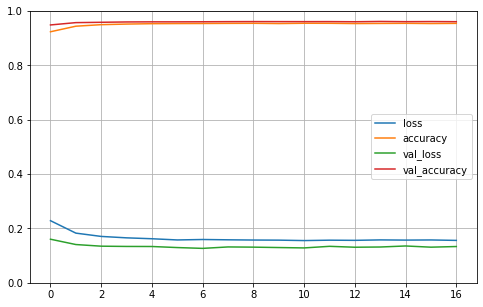

In [23]:
"""Graph training and validation loss/accuracy."""

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

In [22]:
"""To get an idea of what kinds of things the model fails at predicting correctly,
we'll get clean predictions on some of the training set here,
and below, we'll evaluate and look at some misclassified instances."""

from scikeras.wrappers import KerasClassifier

#Make sure we have the sampled version of X_train_v.
vectorize_and_select_pipeline.set_params(vectorize__ngram_range=(1,2),
                                         vectorize__tokenizer=tokenizer_simple,
                                         select__k=20000)
X_train_v = vectorize_and_select_pipeline.fit_transform(X_sampled, y_sampled)
X_train_v = X_train_v.toarray()

keras_clf = KerasClassifier(model=build_mlp_model(n_hidden=3, n_neurons=30, dropout_rate=0.3, input_shape=20000,),
                            epochs=7, #It looked like this was the epoch with peak validation above (this might overfit here, but should be close to best).
                            verbose=1)

y_train_pred = cross_val_predict(keras_clf, X_train_v, y_sampled, cv=3)

INFO:tensorflow:Assets written to: ram:///var/folders/3d/8nmtnnsj0n53170j0cb2mtdr0000gn/T/tmpafvkqtbx/assets
Epoch 1/7
625/625 [==============================] - 10s 14ms/step - loss: 0.4195 - accuracy: 0.8088
Epoch 2/7
625/625 [==============================] - 8s 13ms/step - loss: 0.2778 - accuracy: 0.8897
Epoch 3/7
625/625 [==============================] - 8s 13ms/step - loss: 0.2478 - accuracy: 0.9017
Epoch 4/7
625/625 [==============================] - 9s 14ms/step - loss: 0.2398 - accuracy: 0.9086
Epoch 5/7
625/625 [==============================] - 8s 14ms/step - loss: 0.2228 - accuracy: 0.9147
Epoch 6/7
625/625 [==============================] - 8s 13ms/step - loss: 0.2204 - accuracy: 0.9164
Epoch 7/7
313/313 [==============================] - 1s 3ms/step
INFO:tensorflow:Assets written to: ram:///var/folders/3d/8nmtnnsj0n53170j0cb2mtdr0000gn/T/tmpmum1ov7v/assets
Epoch 1/7
625/625 [==============================] - 10s 14ms/step - loss: 0.4224 - accuracy: 0.8087
Epoch 2/7
625/6

In [26]:
print('Cross-validated training evaluation:', '\n\n',
      'Confusion Matrix:\n', confusion_matrix(y_sampled, y_train_pred), '\n\n',
      'Precision: ', precision_score(y_sampled, y_train_pred), '\n',
      'Recall:    ', recall_score(y_sampled, y_train_pred), '\n',
      'F_1:       ', f1_score(y_sampled, y_train_pred),
     )

Cross-validated training evaluation: 

 Confusion Matrix:
 [[16534  1228]
 [ 1233 11005]] 

 Precision:  0.8996157933458677 
 Recall:     0.8992482431769897 
 F_1:        0.899431980711863


In [178]:
"""Look at the words most predictive of toxicity. (Toxic words commented out for decency.)"""

selection_mask = vectorize_and_select_pipeline['select'].get_support()
words = vectorize_and_select_pipeline['vectorize'].get_feature_names_out()[selection_mask]

x = np.eye(X_train_v.shape[1])
probs = model.predict(x)[:, 0]
ind = np.argsort(probs)

num = 5

non_toxic_words = words[ind[:num]]
toxic_words = words[ind[-num:]]

print('Non-toxic words: ', non_toxic_words, '\n')
#print('Toxic words: ', toxic_words)

625/625 [==============================] - 3s 4ms/step
Non-toxic words:  ['robbery' 'robert' 'the graceful' 'the grammar' 'until have'] 



Those make sense I guess, but if you run the full thing with a higher num, you get some that completely don't make sense -- in particular, some of the most highly rated non-toxic words are definitely toxic. Maybe some of these only appear in texts with many more common and strongly predictive toxic words, so their presence alone indicates nothing to the machine?

In [3]:
"""Prints the text and toxicity tag for posts containing word. Replace word with an offensive word the machine thought
highly predictive of non-toxicity to see that my hypothesis above might be correct."""

word = 'robbery'

[full_data[['comment_text', 'toxic']].iloc[row_num]
 for row_num in full_data.index
 if (word in full_data['comment_text'][row_num])][:2]

[comment_text    i found this article on crime in managua its f...
 toxic                                                           0
 Name: 1967, dtype: object,
 comment_text    "\n\nTo Tha Undertaker\nIf you want to promote...
 toxic                                                           0
 Name: 2828, dtype: object]

In [140]:
X_train_v.shape[1]

20000

In [27]:
"""Look at some misclassified instances (using cross-validated clean training predictions)."""

toxic_marked_clean = X_sampled[(y_sampled == 1) & (y_train_pred == 0)]
clean_marked_toxic = X_sampled[(y_sampled == 0) & (y_train_pred == 1)]

In [41]:
"""Entertaining... (commented out for decency)""";

#pd.options.display.max_colwidth = 1000
#toxic_marked_clean[:10]

In [42]:
"""Also somewhat entertaining... (and also commented out for decency)""";

#pd.options.display.max_colwidth = 1000
#clean_marked_toxic[:10]

In [153]:
"""Now we'll test out some made-up examples with the fully trained model.
The outputs can be interpreted as probabilities that the text is offensive."""

model = keras.models.load_model('keras_model_bow.h5')

post1 = 'This should be fine.'
post2 = 'This should be less fine because it call you a pretentious idiot.'
posts = [post1, post2]
posts_v = vectorize_and_select_pipeline.transform(posts).toarray()

model.predict(posts_v)

1/1 [==============================] - 0s 73ms/step


array([[0.11747551],
       [0.9352799 ]], dtype=float32)

In [28]:
"""Evaluate the model on the test set."""

X_test_v = vectorize_and_select_pipeline.transform(X_test)
X_test_v = X_test_v.toarray()

test_pred_probs = model.predict(X_test_v)
test_pred_classes = [0 if prob < 0.5 else 1 for prob in test_pred_probs]

print('Test set evaluation', '\n',
      'Confusion Matrix:\n', confusion_matrix(y_test, test_pred_classes), '\n\n',
      'Precision: ', precision_score(y_test, test_pred_classes), '\n',
      'Recall:    ', recall_score(y_test, test_pred_classes), '\n',
      'F_1:       ', f1_score(y_test, test_pred_classes),
     )

998/998 [==============================] - 4s 4ms/step
Test set evaluation 
 Confusion Matrix:
 [[28521   338]
 [  950  2106]] 

 Precision:  0.8617021276595744 
 Recall:     0.6891361256544503 
 F_1:        0.7658181818181818
